Cellpose version: 4.0.1 (major number: 4)
(1618, 1610, 3)
PyTorch using GPU: True


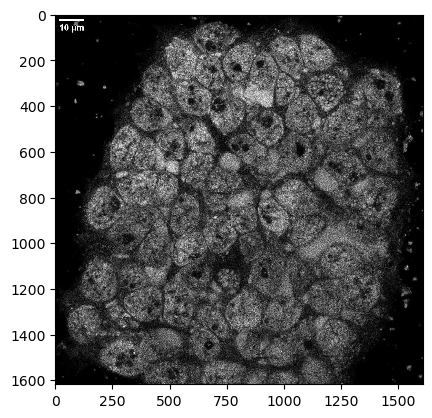

In [2]:
from skimage.io import imread
import matplotlib.pyplot as plt
import cellpose
from cellpose import models, io
from tnia.plotting.plt_helper import random_label_cmap, mask_overlay
import os

parent_path = r"D:\images\tnia-python-images\imagesc\2025_05_17_dense_nuclei"
im_name = r"Screen Shot 2025-05-16 at 5.25.59 PM.jpg"
image = imread(os.path.join(parent_path, im_name))

plt.imshow(image, cmap='gray')

major_number = cellpose.version.split('.')[0]
print(f"Cellpose version: {cellpose.version} (major number: {major_number})")

print(image.shape)
plt.imshow(image, cmap='gray')

# is pytorch using GPU
import torch
print(f"PyTorch using GPU: {torch.cuda.is_available()}")

In [3]:
import time

if major_number == '3':
    model = models.Cellpose(gpu=True, model_type='cyto3')
elif major_number == '4':
    model = models.CellposeModel(gpu=True)


Diameter: 15, Time taken: 17.84 seconds
Diameter: 30, Time taken: 5.65 seconds
Diameter: 60, Time taken: 1.51 seconds
Diameter: 120, Time taken: 1.11 seconds


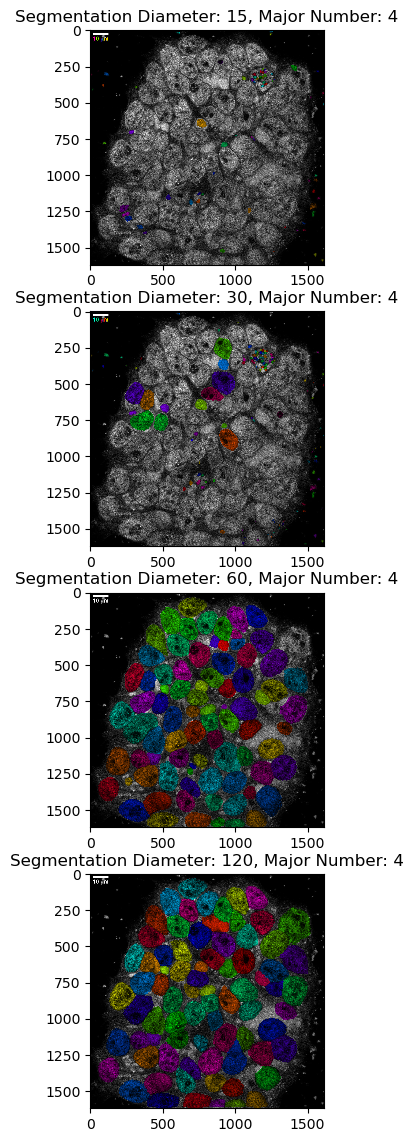

In [4]:
diameters = [6, 15, 30, 60, 120, 240, 360, 720]
diameters = [15, 30, 60, 120]
results = []
fig, axes = plt.subplots(len(diameters), 1, figsize=(10, len(diameters) * 3.5))

for row, d in enumerate(diameters):
    
    start = time.time()
    result = model.eval(image, diameter=d)
    print(f"Diameter: {d}, Time taken: {time.time() - start:.2f} seconds")
    
    results.append(result[0])

    overlay = mask_overlay(image, result[0])
    axes[row].imshow(overlay)
    axes[row].set_title(f"Segmentation Diameter: {d}, Major Number: {major_number}")

fig.savefig(f'cellpose_diameter_{cellpose.version}.png', dpi=300, bbox_inches='tight')

In [8]:
from skimage.measure import regionprops
import numpy as np

def filter_objects(label_image, min_area, max_area):
    """ filters small objects and keeps large objects 

    Args:
        image (np array): original intensity image which objects were segmented from
        label_image (np array):  segmented objects labeled with integer indexes
        max_area (number): min area to keep 

    Returns:
        [np array]: label image with filtered labels set to zero
    """

    object_list=regionprops(label_image)
    label_image_filtered=np.zeros_like(label_image)

    for obj in object_list:
        
        if obj.area > min_area and obj.area < max_area:
            label_image_filtered[label_image==obj.label]=obj.label

    return label_image_filtered

0 6
0.0 226.1946710584651
6 15
28.274333882308138 1413.7166941154069
15 30
176.71458676442586 5654.8667764616275
30 60
706.8583470577034 22619.46710584651
60 120
2827.4333882308138 90477.86842338604
120 240
11309.733552923255 361911.47369354416


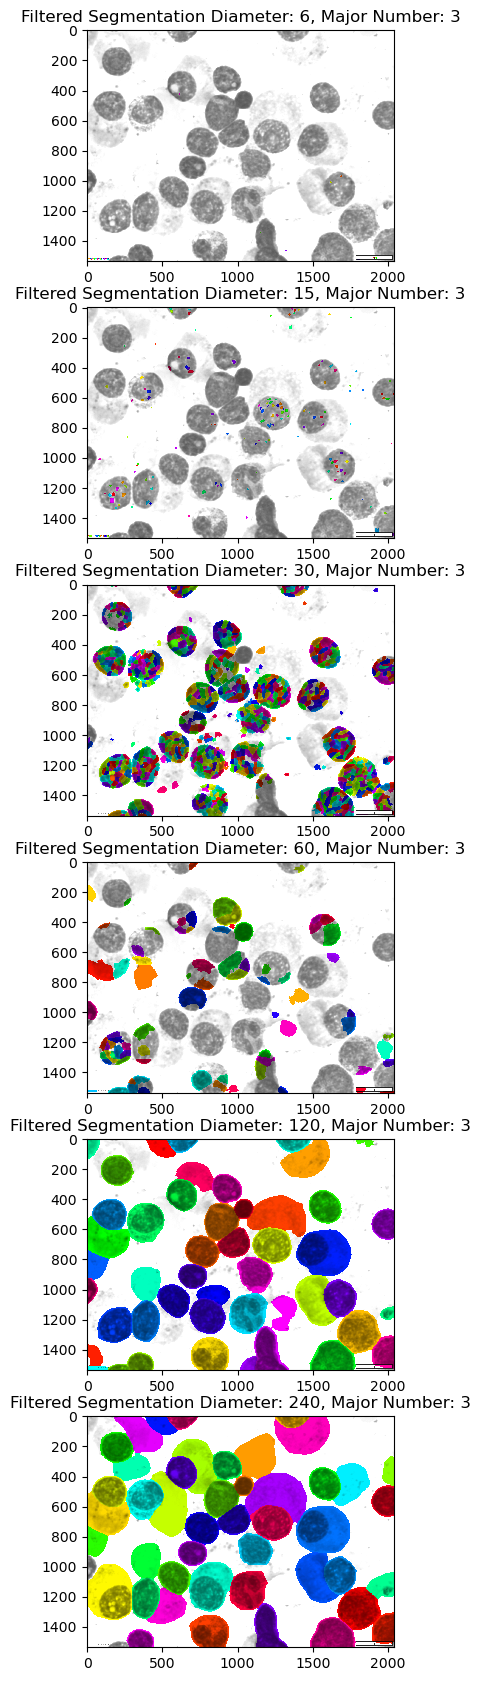

In [9]:
import math
filtered_results = []

fig, axes = plt.subplots(len(diameters), 1, figsize=(15, len(diameters) * 3.5))

for i, result in enumerate(results):
    min_d = diameters[i-1] if i > 0 else 0
    max_d = diameters[i]

    min_area = math.pi * (min_d / 2) ** 2 
    max_area = math.pi * (max_d / 2) ** 2 * 8
    
    filtered_result = filter_objects(result, min_area=min_area, max_area=max_area)
    
    print(min_d, max_d)
    print(min_area, max_area) 

    filtered_results.append(filtered_result)

    overlay = mask_overlay(image, filtered_result)
    axes[i].imshow(overlay)
    axes[i].set_title(f"Filtered Segmentation Diameter: {diameters[i]}, Major Number: {major_number}")
    

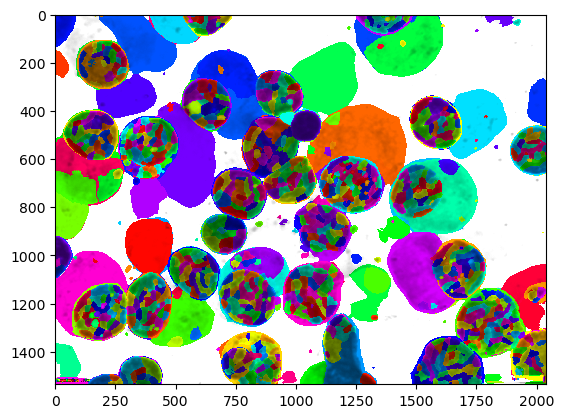

In [10]:
# reverse filtered results
reversed_results = filtered_results.copy()
reversed_results.reverse()

merged_result = np.zeros_like(filtered_results[0])

for r in reversed_results:
    # copy non-zero values from r to merged_result
    merged_result[r > 0] = r[r > 0] + merged_result.max()

overlay = mask_overlay(image, merged_result)
plt.imshow(overlay)

plt.savefig(f'merged_{cellpose.version}.png', dpi=300, bbox_inches='tight')

In [6]:
import napari

viewer = napari.Viewer()
viewer.add_image(image, name='image')
viewer.add_labels(merged_result, name='merged_result')
viewer.add_labels(results[0], name='segmentation_1')

<Labels layer 'segmentation_1' at 0x17bcc8d6310>